#Inteligencia Artificial 2019-1 Proyecto Agricultura

Cristian Andrés Picón Rodríguez - 2160082\
Andrea Juliana Villalba Santos    - 2162114 \

## Import lines

In [1]:
import os
import sys

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import *


from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


##_ Creation of the useful DataSet

### Fixing Data:

In [0]:
#Obtener los Dataset

DATA_DIR   = "/content/drive/My Drive/AI_2019/Project/Project_Data/"
csvList    = []
csvMapName = {}
for index,csvName in enumerate(os.listdir(DATA_DIR)):
  csvList.append(pd.read_csv(DATA_DIR + csvName))
  structure = csvName.split('_')
  #print(csvName)
  csvMapName.update({
      structure[2] : csvList[index]
  }) 

In [0]:
#Quitar las columnas que nos sirven del dataset cargado y ponerlas en el nuevo.

csvDataMap  = {}
csvDataList = []
for index,i in enumerate(csvMapName):
  Dtemp = pd.DataFrame(csvMapName[i])
  tempCol = Dtemp.columns
  csvDataset = pd.DataFrame({tempCol[1]:Dtemp[tempCol[1]],
                            tempCol[3]:Dtemp[tempCol[3]],
                            tempCol[5]:Dtemp[tempCol[5]],
                            tempCol[10]:Dtemp[tempCol[10]],
                            tempCol[11]:Dtemp[tempCol[11]],
                            tempCol[12]:Dtemp[tempCol[12]],
                            tempCol[13]:Dtemp[tempCol[13]],
                            tempCol[14]:Dtemp[tempCol[14]]})
  csvDataMap.update({i:csvDataset})
for i in csvDataMap:
  csvDataMap[i].columns=['DEPARTAMENTO','MUNICIPIO','CULTIVO',
                                'PERIODO','Área Sembrada(ha)','Área Cosechada(ha)',
                                'Producción(t)','Rendimiento(t/ha)']

In [0]:

csvDataMap['Maiz'].head()

,DEPARTAMENTO,MUNICIPIO,CULTIVO,PERIODO,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha)
0,ANTIOQUIA,PUERTO BERRIO,MAIZ FORRAJERO,2018A,150,150,4200,28.0
1,ANTIOQUIA,LA UNION,MAIZ FORRAJERO,2018A,23,22,726,33.0
2,CESAR,EL PASO,MAIZ FORRAJERO,2018A,320,74,222,3.0
3,CESAR,SAN ALBERTO,MAIZ FORRAJERO,2018A,35,0,0,0.0
4,CESAR,GONZALEZ,MAIZ FORRAJERO,2018A,31,0,0,0.0


In [0]:
csvDataMap['Maiz'].info()
csvDataMap['Maiz'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8464 entries, 0 to 8463
Data columns (total 8 columns):
DEPARTAMENTO          8464 non-null object
MUNICIPIO             8464 non-null object
CULTIVO               8464 non-null object
PERIODO               8464 non-null object
Área Sembrada(ha)     8464 non-null int64
Área Cosechada(ha)    8464 non-null int64
Producción(t)         8464 non-null int64
Rendimiento(t/ha)     8464 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 529.1+ KB


,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha)
count,8464.000000,8464.000000,8464.000000,8464.000000
mean,264.245274,227.353025,663.750354,2.105919
std,925.831913,812.994040,4505.049040,3.444738
min,0.000000,0.000000,0.000000,0.000000
25%,15.000000,10.000000,16.000000,1.000000
50%,53.000000,45.000000,75.000000,1.500000
75%,215.000000,180.000000,339.250000,2.200000
max,33500.000000,32000.000000,210000.000000,45.000000


Para el tratamiento de datos es necesario reemplazar todos los datos alfanúmericos en el Data Frame por valores númericos. \
En los siguientes Dataframes se encuentran los Departamentos, Municipios, Subgrupo de Cultivo y Perido con sus respectivos ID.

In [0]:
DepId = {}
tempFullMap = []
tempRow = []
newData = pd.DataFrame()
for index,i in enumerate(csvDataMap):
  tempData = csvDataMap[i]        #Cada Dataset 
  tempCol = tempData.columns #Nombre de las columnas del Dataset
  tempColData = tempData[tempCol[0]].drop_duplicates()
  for k in tempColData:
    tempRow.append(k)
final = pd.Series(sorted(tempRow)).drop_duplicates()
final = final.reset_index()
del final['index']
final = final.rename(columns = {0:'Departamento'})
for m,n in enumerate(final['Departamento']):
  DepId.update({m:n})
print(final.shape)
final.head()

(32, 1)


,Departamento
0,AMAZONAS
1,ANTIOQUIA
2,ARAUCA
3,ATLANTICO
4,BOLIVAR


In [0]:
for index,i in enumerate(csvDataMap):    #Cada Dataset 
  for j in final['Departamento']:        #Cada Departamento
    cont = csvDataMap[i][csvDataMap[i].DEPARTAMENTO==j]['DEPARTAMENTO'].index
    if(cont.size > 0):
      for p in cont:
        csvDataMap[i].loc[p,'DEPARTAMENTO'] = list(DepId.keys())[list(DepId.values()).index(j)]        

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
MunId = {}
tempFullMap = []
tempRow = []
newData = pd.DataFrame()
for index,i in enumerate(csvDataMap):
  tempData = csvDataMap[i]        #Cada Dataset 
  tempCol = csvDataMap[i].columns #Nombre de las columnas del Dataset
  tempColData = tempData[tempCol[1]].drop_duplicates()
  for k in tempColData:
    tempRow.append(k)
final = pd.Series(sorted(tempRow)).drop_duplicates()
final = final.reset_index()
del final['index']
final = final.rename(columns = {0:'Municipio'})
for m,n in enumerate(final['Municipio']):
  MunId.update({m:n})
print(final.shape)
final.head(5)

(990, 1)


,Municipio
0,ABEJORRAL
1,ABREGO
2,ABRIAQUI
3,ACACIAS
4,ACANDI


In [0]:
for index,i in enumerate(csvDataMap):    #Cada Dataset 
  for j in final['Municipio']:        #Cada Departamento
    cont = csvDataMap[i][csvDataMap[i].MUNICIPIO==j]['MUNICIPIO'].index
    if(cont.size > 0):
      for p in cont:
        csvDataMap[i].loc[p,'MUNICIPIO'] = list(MunId.keys())[list(MunId.values()).index(j)]        

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
GrupId = {}
tempFullMap = []
tempRow = []
newData = pd.DataFrame()
for index,i in enumerate(csvDataMap):
  tempData = csvDataMap[i]        #Cada Dataset 
  tempCol = csvDataMap[i].columns #Nombre de las columnas del Dataset
  tempColData = tempData[tempCol[2]].drop_duplicates()
  for k in tempColData:
    tempRow.append(k)
final = pd.Series(sorted(tempRow)).drop_duplicates()
final = final.reset_index()
del final['index']
final = final.rename(columns = {0:'Cultivo'})
for m,n in enumerate(final['Cultivo']):
  GrupId.update({m:n})
final.head()

,Cultivo
0,AGUACATE
1,CACAO
2,CAFE
3,MAIZ
4,MAIZ FORRAJERO


In [0]:
for index,i in enumerate(csvDataMap):    #Cada Dataset 
  for j in final['Cultivo']:        #Cada Departamento
    cont = csvDataMap[i][csvDataMap[i].CULTIVO==j]['CULTIVO'].index
    if(cont.size > 0):
      for p in cont:
        csvDataMap[i].loc[p,'CULTIVO'] = list(GrupId.keys())[list(GrupId.values()).index(j)]     

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
PerId = {}
tempFullMap = []
tempRow = []
newData = pd.DataFrame()
for index,i in enumerate(csvDataMap):
  tempData = csvDataMap[i]        #Cada Dataset 
  tempCol = csvDataMap[i].columns  #Nombre de las columnas del Dataset
  tempColData = tempData[tempCol[3]].drop_duplicates()
  for k in tempColData:
    tempRow.append(k)
final = pd.Series(tempRow).drop_duplicates()
final = final.reset_index()
del final['index']
final = final.rename(columns = {0:'Periodo'})
for m,n in enumerate(final['Periodo']):
  PerId.update({m:n})
final.head()

,Periodo
0,2018
1,2017
2,2016
3,2018A
4,2017A


In [0]:
for index,i in enumerate(csvDataMap):    #Cada Dataset 
  for j in final['Periodo']:        #Cada Periodo
    cont = csvDataMap[i][csvDataMap[i].PERIODO==j]['PERIODO'].index
    if(cont.size > 0):
      for p in cont:
        csvDataMap[i].loc[p,'PERIODO'] = list(PerId.keys())[list(PerId.values()).index(j)]     

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
csvDataMap['Maiz'].head()


,DEPARTAMENTO,MUNICIPIO,CULTIVO,PERIODO,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha)
0,1,635,4,3,150,150,4200,28.0
1,1,435,4,3,23,22,726,33.0
2,10,275,4,3,320,74,222,3.0
3,10,717,4,3,35,0,0,0.0
4,10,342,4,3,31,0,0,0.0


**Saving the datasets into a new csv.**

In [0]:
DATA_DIR2 = "/content/drive/My Drive/AI_2019/Project/DataT/"
for i in csvDataMap: # csvDataMap es el diccionario que contiene todos los dataset
  csvDataMap[i].to_csv(DATA_DIR2+i+'.csv')
  

### To obtain the new data. (Final Data)

In [0]:
DATA_DIR   = "/content/drive/My Drive/AI_2019/Project/DataT/"
csvList    = []
csvDataMap = {}
for index,csvName in enumerate(os.listdir(DATA_DIR)):
  csvList.append(pd.read_csv(DATA_DIR + csvName))
  structure = csvName.split('.')
  #print(csvName)
  csvDataMap.update({
      structure[0] : csvList[index]
  }) 

In [0]:
for i in csvDataMap:
  del csvDataMap[i][csvDataMap[i].columns[0]]

##The variable csvMapName is a Dictionary with the Datasets
\
The Keys to get every Datasets are:

In [4]:
keys=list(csvDataMap.keys())  ##Listar las keys para acceder a los DataSets
print(keys)

['Cafe', 'Maiz', 'Tomate', 'Soya', 'Cacao', 'Aguacate']


We can access to every Dataset using : 
\
**csvDataMap\['key'] = csvDataMap\['Maiz']**

## Graphics

### Kmeans and DBS

In [25]:
from sklearn.datasets import *
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN


temp = csvDataMap[keys[2]].iloc[:, [1,3,6,7]]
print(temp.head())
for i in temp.columns:
  temp[i].fillna(0,inplace=True)
temp = temp.values

   MUNICIPIO  PERIODO  Producción(t)  Rendimiento(t/ha)
0        602        3          30000              120.0
1        486        3          16320               85.0
2        359        3           8800              110.0
3        210        3           1400               20.0
4        777        3           5720              110.0


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


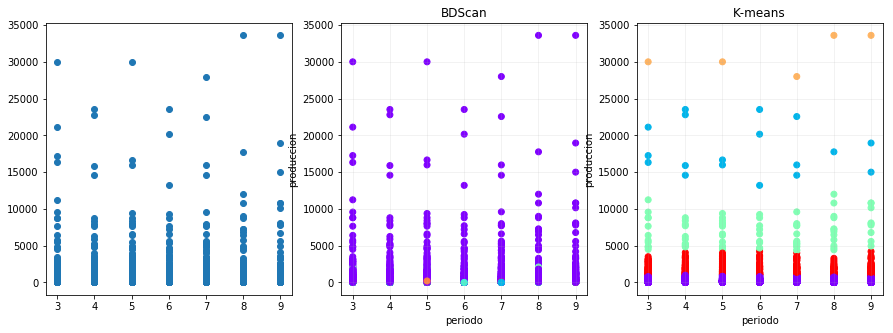

In [7]:
kmeans = KMeans(n_clusters=5)  
kmeans.fit(temp)  

DBS = DBSCAN(eps=10)
#AgglomerativeClustering(n_clusters=2, linkage= "ward")
DBS.fit(temp) 
plt.figure(figsize=(15, 5))  
plt.subplot(131)
plt.scatter(temp[:,1], temp[:,2], cmap='rainbow') 
plt.subplot(132)
plt.title("BDScan")
plt.xlabel("periodo")
plt.ylabel("produccion")
plt.grid(alpha=0.2)
plt.scatter(temp[:,1], temp[:,2], c=DBS.labels_, cmap='rainbow')  
plt.subplot(133)
plt.scatter(temp[:,1], temp[:,2], c=kmeans.labels_, cmap='rainbow') 
plt.xlabel("periodo")
plt.ylabel("produccion")
plt.title("K-means")
plt.grid(alpha=0.2)

It can be noted that Kmeans did not classify by periods but by levels of production, regardless of the time or period the amount of production is classified.

(array([ 71.,  82.,  78.,  54.,  82.,  87., 100.,  48.,  52.,  33.,  86.,
         31.,  76.,  51.,  62.,  94.,  84., 119.,  85.,  91.,  70.,  99.,
         65.,  44.,  87.,  42.,  27.,  52.,  50.,  71.,  67.,  51.,   2.,
         49.,  93.,  83., 102.,  39.,  73.,  74.,  80.,  38.,  66.,  74.,
        102.,  80.,  47.,  98.,  92.,  64.]),
 array([  1.  ,  20.76,  40.52,  60.28,  80.04,  99.8 , 119.56, 139.32,
        159.08, 178.84, 198.6 , 218.36, 238.12, 257.88, 277.64, 297.4 ,
        317.16, 336.92, 356.68, 376.44, 396.2 , 415.96, 435.72, 455.48,
        475.24, 495.  , 514.76, 534.52, 554.28, 574.04, 593.8 , 613.56,
        633.32, 653.08, 672.84, 692.6 , 712.36, 732.12, 751.88, 771.64,
        791.4 , 811.16, 830.92, 850.68, 870.44, 890.2 , 909.96, 929.72,
        949.48, 969.24, 989.  ]),
 <a list of 50 Patch objects>)

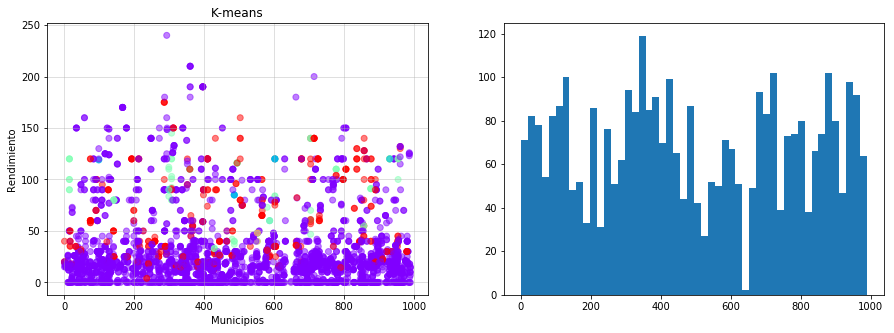

In [9]:
kmeans = KMeans(n_clusters=5)  
kmeans.fit(temp)  

#DBS = DBSCAN(eps=10)
#AgglomerativeClustering(n_clusters=2, linkage= "ward")
DBS.fit(temp) 
plt.figure(figsize=(15, 5))  
plt.subplot(121)
plt.scatter(temp[:,0], temp[:,3], c=kmeans.labels_, cmap='rainbow',alpha=0.5) 
plt.xlabel("Municipios")
plt.ylabel("Rendimiento")
plt.title("K-means")
plt.grid(alpha=0.5)
plt.subplot(122)
plt.hist(temp[:,0], bins = 50)

Production in some municipalities is lower in this crop, this is due to territorial factors such as soil type, climate, among others.

Text(0.5, 0.92, 'Municipio vs Periodo vs Producción')

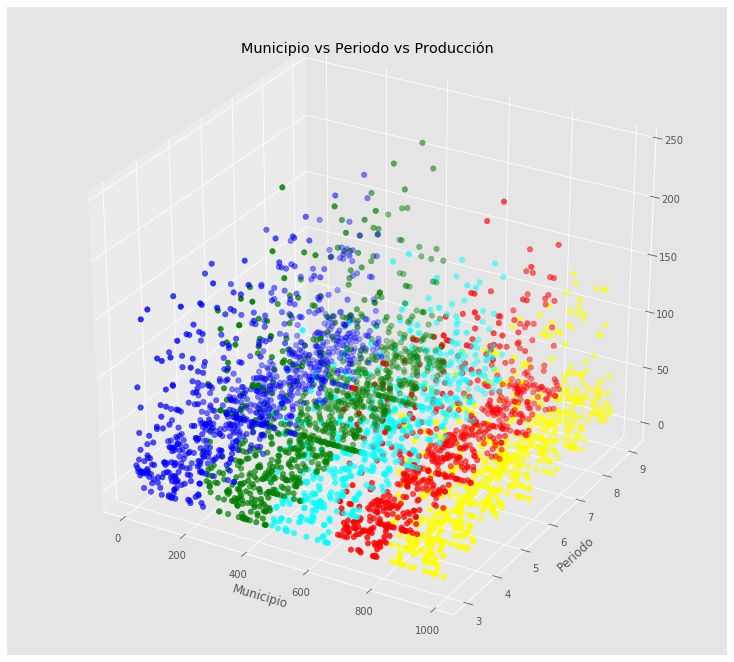

In [26]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10, 9)
plt.style.use('ggplot')

data = temp[:,[0,1,3]]

kmeans = KMeans(n_clusters=5).fit(data)
centroids = kmeans.cluster_centers_

# Predicting the clusters
labels = kmeans.predict(data)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=asignar,s=30)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='.', c=colores, s=1000)
plt.xlabel("Municipio")
plt.ylabel("Periodo")
plt.title("Municipio vs Periodo vs Producción")

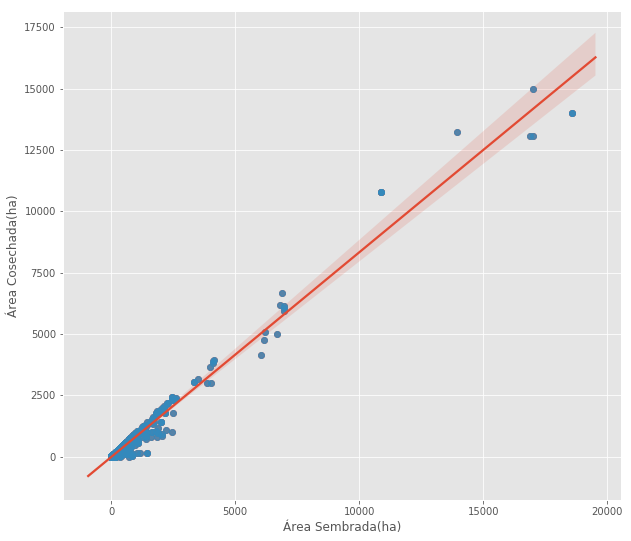

In [27]:
temp = csvDataMap[keys[4]]


# library & dataset
import seaborn as sns
 
  
# use the function regplot to make a scatterplot
sns.regplot(x=temp["Área Sembrada(ha)"], y=temp["Área Cosechada(ha)"])
#sns.plt.show()
 
# Without regression fit:
sns.regplot(x=temp["Área Sembrada(ha)"], y=temp["Área Cosechada(ha)"], fit_reg=False)
#sns.plt.show()

In [0]:
locations = pd.read_csv("/content/drive/My Drive/AI_2019/Project/departamentoscolombia.csv")
del locations["numero_dep"]

In [13]:
for i in range(len(locations)):  #Asignar un Id a cada Departamento
    locations["departamento"][i] = i  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
##Promedia la producción por Departamento de cada Dataset

prom_prod = []
for i in range(len(csvDataMap)): 
  t = csvDataMap[keys[i]]
  prom_prod.append([])
  for j in range(len(locations)):
    prom_prod[i].append(np.mean(t[t.DEPARTAMENTO==j]["Producción(t)"]))
  locations["prom" + keys[i]] = prom_prod[i]

In [0]:
for i in keys:
  name = "prom"+i
  locations[name].fillna(0,inplace=True)

In [16]:
locations.head()

,departamento,latitud,longitud,promCafe,promMaiz,promTomate,promSoya,promCacao,promAguacate
0,0,-1.019722,-71.938333,0.000000,32.000000,1.428571,0.0,7.833333,104.000000
1,1,7.000000,-75.500000,1426.492908,275.985272,1301.769585,0.0,149.630769,1437.417021
2,2,7.090278,-70.761667,0.000000,1443.081633,0.000000,0.0,1346.714286,721.187500
3,3,10.750000,-75.000000,0.000000,189.525510,115.448276,0.0,0.000000,55.000000
4,4,9.000000,-74.333333,435.500000,1207.575301,1.000000,0.0,131.516667,3132.666667


### Avocado production


In [0]:
y = locations["latitud"]
x = locations["longitud"]
n = locations["departamento"]

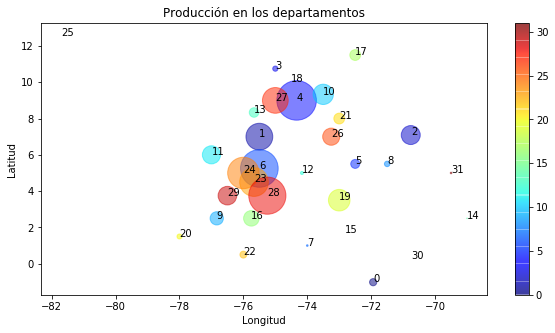

In [18]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.5, s=locations["promAguacate"]*0.5, c=locations["departamento"], cmap=plt.get_cmap("jet"))
plt.title('Producción en los departamentos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))

### Cocoa production

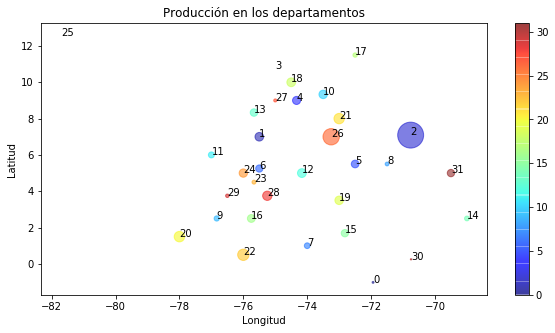

In [19]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.5, s=locations["promCacao"]*0.5, c=locations["departamento"], cmap=plt.get_cmap("jet"))
plt.title('Producción en los departamentos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))

### Coffee production

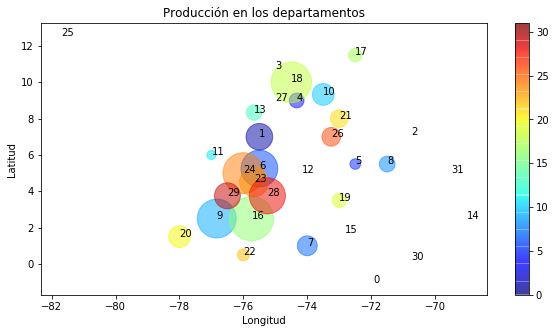

In [20]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.5, s=locations["promCafe"]*0.5, c=locations["departamento"], cmap=plt.get_cmap("jet"))
plt.title('Producción en los departamentos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))

### Corn production

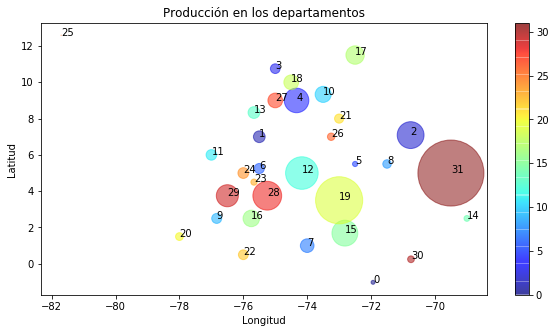

In [21]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.5, s=locations["promMaiz"]*0.5, c=locations["departamento"], cmap=plt.get_cmap("jet"))
plt.title('Producción en los departamentos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))

### Soy production

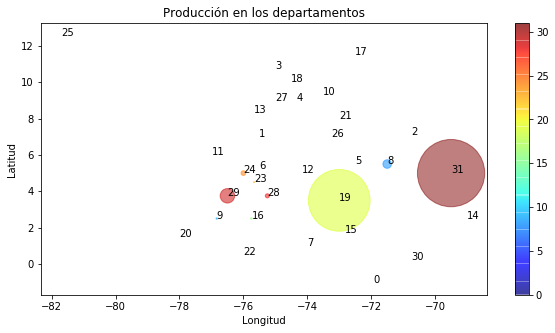

In [22]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.5, s=locations["promSoya"]*0.5, c=locations["departamento"], cmap=plt.get_cmap("jet"))
plt.title('Producción en los departamentos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))

### Tomato production

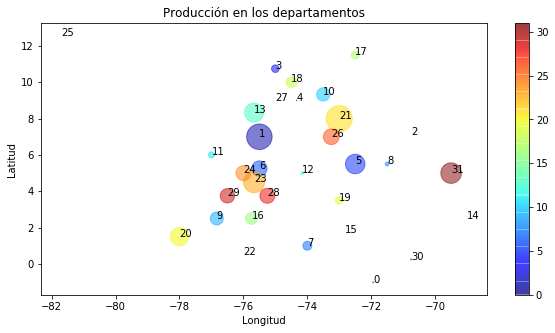

In [23]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
plt.scatter(x, y, alpha=0.5, s=locations["promTomate"]*0.5, c=locations["departamento"], cmap=plt.get_cmap("jet"))
plt.title('Producción en los departamentos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar();

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))

## Data Treatment - Regression


In [0]:
dataset = csvDataMap['Cafe']

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2.0, right=2.0
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=2.0, top=2.0
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2.0, right=2.0
  ax.set_xlim(boundaries_list[i])


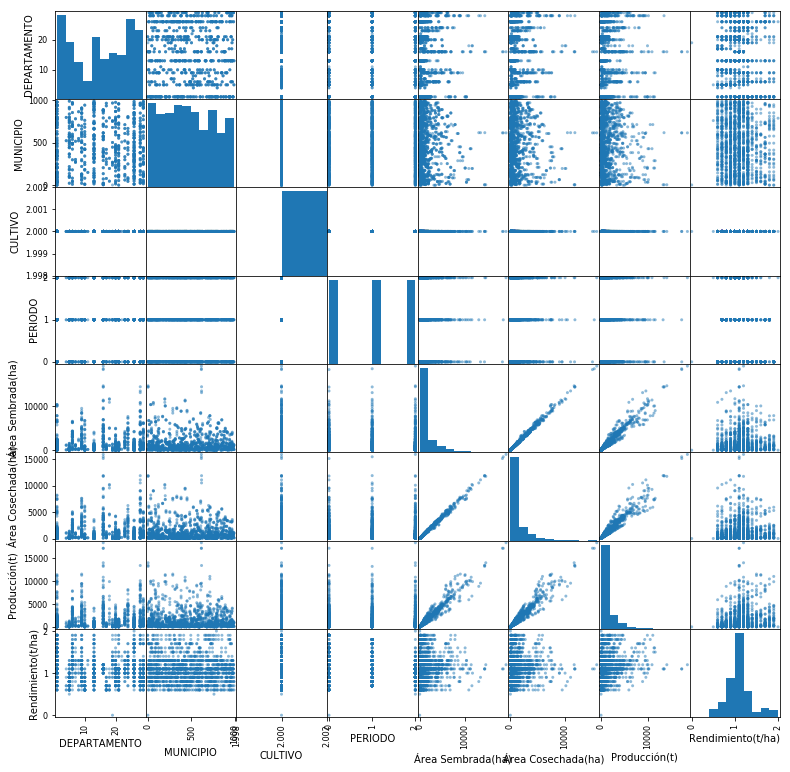

In [0]:
pd.plotting.scatter_matrix(dataset, figsize=(13,13),marker = '.');

In [0]:
dataset.describe()

,DEPARTAMENTO,MUNICIPIO,CULTIVO,PERIODO,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha)
count,1799.000000,1799.000000,1799.0,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000
mean,15.276820,471.160645,2.0,0.998332,1511.943302,1263.698166,1423.785436,1.088660
std,9.528429,285.606433,0.0,0.816608,2165.030511,1780.815050,2083.344878,0.293144
min,1.000000,0.000000,2.0,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,235.000000,2.0,0.000000,213.500000,184.500000,190.000000,0.900000
50%,16.000000,446.000000,2.0,1.000000,741.000000,642.000000,661.000000,1.100000
75%,26.000000,716.500000,2.0,2.000000,1789.500000,1517.500000,1701.000000,1.200000
max,29.000000,987.000000,2.0,2.000000,19119.000000,15931.000000,18440.000000,2.000000


In [0]:
dataset.head()

,DEPARTAMENTO,MUNICIPIO,CULTIVO,PERIODO,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha)
0,1,35,2,0,10380,7648,9888,1.3
1,1,201,2,0,10063,7374,11439,1.6
2,1,711,2,0,7857,5929,11057,1.9
3,1,210,2,0,6880,5306,9896,1.9
4,1,91,2,0,6445,4749,7368,1.6


In [0]:
X = dataset.values[:,[0,4]]
y = dataset.values[:,6:7]

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [0]:
def show_curve(est):
    means, stds = [], []
    nfolds_range = range(2,11)
    for nfolds in nfolds_range:
      #print(nfolds,)
      f = cross_val_score(est, X, y.ravel(), cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
      means.append(np.mean(f))
      stds.append(np.std(f))

    means = np.r_[means]
    stds  = np.r_[stds]

    plt.plot(nfolds_range, means, label="mean", color="black")
    plt.fill_between(nfolds_range, means-stds, means+stds, color="blue", alpha=.5, label="std")
    plt.xlabel("n folds")
    plt.ylabel("performance")
    plt.legend()

### Decision Tree Regressor

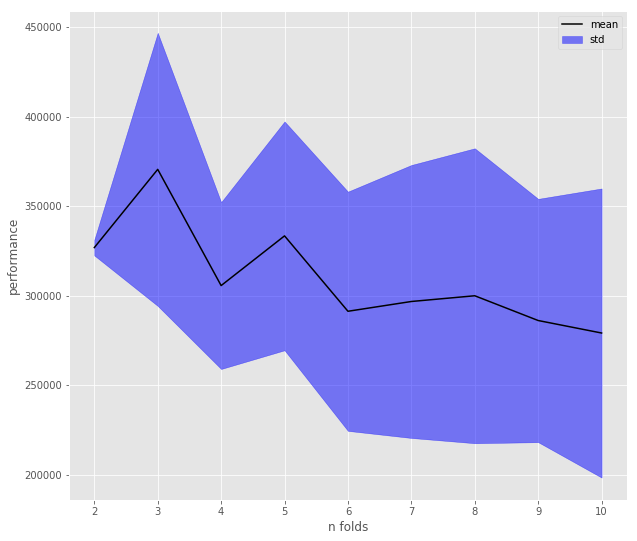

In [0]:
show_curve(DecisionTreeRegressor())

In [0]:
# Normalizacion de los datos de entrenamiento y test
Xnormalizer = StandardScaler().fit(X_train)
XTnormalizer = StandardScaler().fit(X_test)
Ynormalizer = StandardScaler().fit(y_train)
XTrain = Xnormalizer.transform(X_train)
YTrain = Ynormalizer.transform(y_train)
XTest = XTnormalizer.transform(X_test)


DTR = DecisionTreeRegressor()
DTR.fit(X_train,y_train)

s = cross_val_score(DTR, XTrain, YTrain, cv=KFold(10, shuffle=True), scoring=make_scorer(mean_squared_error))
print("MSE %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

MSE 0.067 (+/- 0.02774)


### SVR

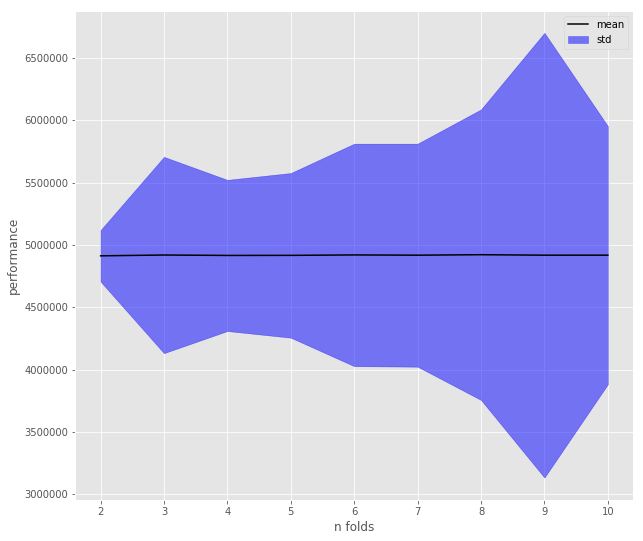

In [0]:
from sklearn.svm import SVR
show_curve(SVR(gamma='auto'))

In [0]:
svr = SVR(gamma='auto')
svr.fit(X_train,y_train.ravel())
s = cross_val_score(svr, XTrain, YTrain.ravel(), cv=KFold(10, shuffle=True), scoring=make_scorer(mean_squared_error))
print("MSE %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

MSE 0.086 (+/- 0.08603)


### Random Forest Regressor

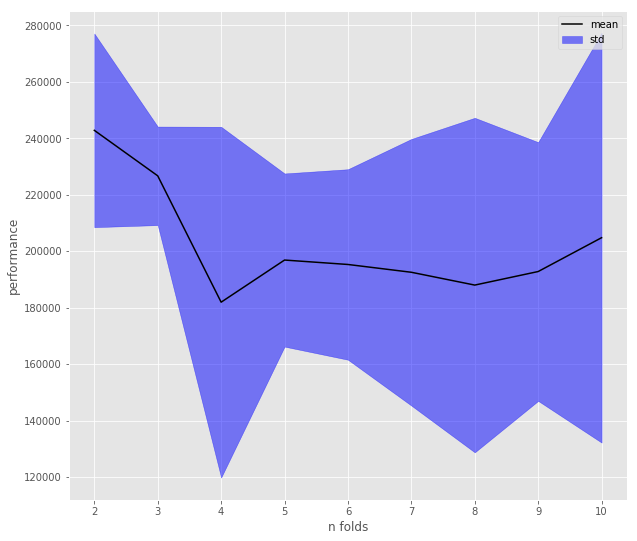

In [0]:
from sklearn.ensemble import RandomForestRegressor
show_curve(RandomForestRegressor(n_estimators = 100))

In [0]:
RFR = RandomForestRegressor(n_estimators=100)
RFR.fit(X_train, y_train.ravel())
s = cross_val_score(RFR, XTrain, YTrain.ravel(), cv=KFold(10, shuffle=True), scoring=make_scorer(mean_squared_error))
print("MSE %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

MSE 0.043 (+/- 0.00864)


### Predictions

In [0]:
DTR_Predictions = DTR.predict(X_test)

In [0]:
SVR_Predictions = svr.predict(X_test)

In [0]:
RFR_Predictions = RFR.predict(X_test)

### Comparing the regressors

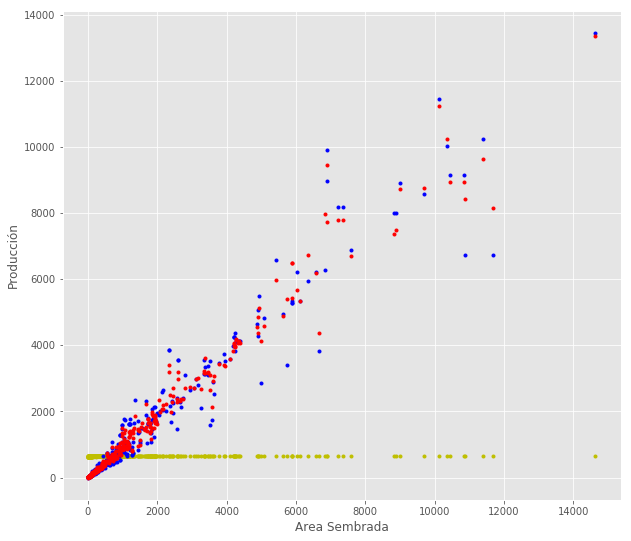

In [0]:
plt.plot(X_test[:,1], SVR_Predictions, 'y.', X_test[:,1], DTR_Predictions, 'b.', X_test[:,1], RFR_Predictions, 'r.')
plt.xlabel("Area Sembrada")
plt.ylabel("Producción")
plt.show()

We note that the RFR and DTR have a similar behavior and that on the other hand the SVR behaves in a way that does not satisfy the problem, that is, the SVR solution is not a solution to our problem.

Text(0, 0.5, 'Produccion')

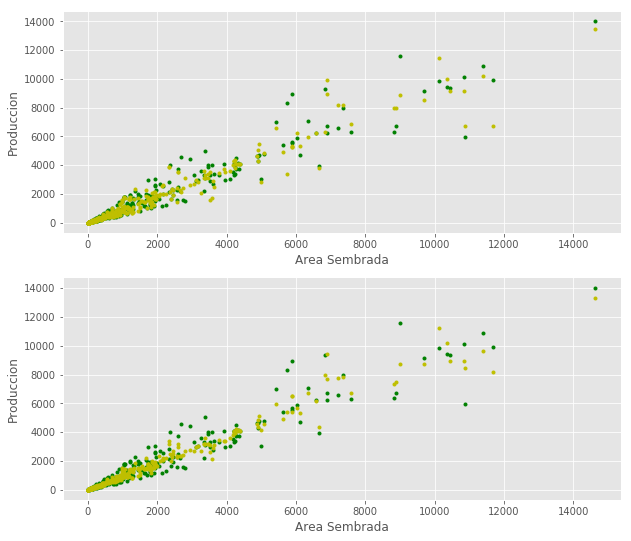

In [0]:

plt.subplot(2, 1, 1)
plt.plot(X_test[:,1], y_test, 'g.',X_test[:,1], DTR_Predictions, 'y.')
plt.xlabel('Area Sembrada')
plt.ylabel('Produccion')
plt.title('Decision Tree Regressor and Real Data')

plt.subplot(2, 1, 2)
plt.plot(X_test[:,1], y_test, 'g.',X_test[:,1], RFR_Predictions, 'y.')
plt.xlabel('Area Sembrada')
plt.ylabel('Produccion')
plt.title('Random Forest Regressor and Real Data')

It can be noted that in both cases the predictions converge towards the actual results.

## Data treatment - Classification

In [0]:
for i in csvDataMap:
  csvDataMap[i]["class"] = ((csvDataMap[i]["Área Cosechada(ha)"] > (csvDataMap[i]["Área Sembrada(ha)"]*0.5)) & (csvDataMap[i]["Área Cosechada(ha)"] <= csvDataMap[i]["Área Sembrada(ha)"]))*1
  

In [45]:
datasetC = csvDataMap["Cafe"]
datasetC.head()

,DEPARTAMENTO,MUNICIPIO,CULTIVO,PERIODO,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha),class
0,1,35,2,0,10380,7648,9888,1.3,1
1,1,201,2,0,10063,7374,11439,1.6,1
2,1,711,2,0,7857,5929,11057,1.9,1
3,1,210,2,0,6880,5306,9896,1.9,1
4,1,91,2,0,6445,4749,7368,1.6,1


In [0]:
from sklearn.model_selection import cross_val_score

X = datasetC.values[:,[0,2,4,5,6]]
y = datasetC.values[:,-1]

In [0]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

In [48]:
from sklearn.naive_bayes import GaussianNB


est = GaussianNB()

s = cross_val_score(est, X, y, cv=KFold(8, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(8, shuffle=True), scoring=tpr)
print ("tpr %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(8, shuffle=True), scoring=tnr)
print ("tnr %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.986 (+/- 0.01164)
tpr 0.989 (+/- 0.00630)
tnr nan (+/- nan)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwa

In [49]:
from sklearn.tree import DecisionTreeClassifier

est = DecisionTreeClassifier()

s = cross_val_score(est, X, y, cv=KFold(8, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(8, shuffle=True), scoring=tpr)
print ("tpr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(8, shuffle=True), scoring=tnr)
print ("tnr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.998 (+/- 0.00222)
tpr      0.999 (+/- 0.00147)
tnr      nan (+/- nan)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwa

In [50]:
from sklearn.ensemble import RandomForestClassifier

est = RandomForestClassifier(n_estimators = 100)

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print ("tpr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print ("tnr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.998 (+/- 0.00369)
tpr      0.999 (+/- 0.00169)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwa

tnr      nan (+/- nan)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
from sklearn.svm import SVC

est = SVC(gamma = 'auto')

s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print ("tpr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print ("tnr      %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.998 (+/- 0.00255)
tpr      1.000 (+/- 0.00000)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwa

tnr      nan (+/- nan)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [53]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, KFold
s = cross_val_score(GaussianNB(), X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("X shape", X.shape)
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

X shape (1799, 5)
accuracy 0.986 (+/- 0.00667)


In [54]:
X = PCA(n_components=3).fit_transform(X)
print ("shape after PCA ", X.shape)
s = cross_val_score(GaussianNB(), X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

shape after PCA  (1799, 3)
accuracy 0.987 (+/- 0.00712)
